In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = .0033 #keV

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [4]:
#x = np.arange(0,200,0.002)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 500000
Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 

#need to store all of this inorder to calculate fano factor.
ER = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []

U1 = []
U2 = []
N_eh = []

QNR=[]
PT1 = []


In [5]:
#For Nuclear Recoils 
F =100

'''
Neh = Y*Enr/eps
#(ylindv(Enr*1000.0)*Enr)/(eps/1000)
sigf_p = q*V*np.sqrt(Neh*F)
sigf_q = eps*np.sqrt(Neh*F)
'''

for i in np.arange(0,N):
    
    Enr = np.random.choice(Er)

    esp = 11.5*Enr*(23)**-(7/3)
    g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
    Y = k*g/(1+k*g)
    

    
    Neh = Y*Enr/eps #number of electron-hole pairs. 
    Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
    Qnr = Y*Enr
    
    
    N_eh.append(Neh)
    #(ylindv(Enr*1000.0)*Enr)/(eps/1000)
    #sigf_p = q*V*np.sqrt(Neh*F)
    #sigf_q = eps*np.sqrt(Neh*F)
    
    
    #Without Fano Factor 
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) )  
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) )
    
   #With Fano Factor. 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F)  #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #Charge uncertainty 
    

    
    sigQ.append(sig_q)
    sigP.append(sig_p)
    sigQ1.append(sig_q1)
    sigP1.append(sig_p1)
    
    Fnr = np.random.normal(0.0,sig_p) #random sample assuming phonon variance 
    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    #Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)

    Qnr1 = Qnr + Fq 

    QNR.append(Qnr1)
    
    U_1 = (Ptnr*eps**2)/((V*Qnr1/1000)-Ptnr1*eps)**2 #derivative with respect to Qnr1
    U1.append(U_1)
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2      #derivative with respect to Ptnf
    U2.append(U_2)
    
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)

    

In [6]:
Yield_er = []
ERer = []



In [7]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [8]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

In [9]:
#plot 

'''
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)

ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)

ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,100)


plt.show()
'''

"\nfig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)\nax1 = axes\n\n\nX = np.arange(0.1,100,0.1)\n\nax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)\nax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)\n\nax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data \n#ax1.plot(xn,yn,'r--') #new fit to data (mean)\n\nax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\\sigma$')\nax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)\n\nax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')\nax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\\sigma$')\nax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)\n\nax1.set_xlabel('Recoil Energy [keV]')\nax1.set_ylabel('Yield')\nax1.set_ylim(0,1.6)\nax1.set_xlim(0,100)\n\n\nplt.show()\n"

In [10]:

data = np.vstack((ER,Yield,sigQ1,sigP1,U1,U2,N_eh)).T
print(data.shape)

x = data[data[:,1]>=0, :]

data1 = x[x[:,1]<=1.6,:]
data2 = data1[data1[:,0]>=0,:]


#data = np.vstack((Er,Y)).T
#print(data)
#np.savetxt("test_data.txt",data)

data1 = data2[np.argsort(data2[:, 0])]



(500000, 7)


In [11]:
#a,b,c,d,e,f,g = np.array_split(data1,7)
data = np.array_split(data1,20)

#print(data)
#data = (a,b,c,d,e,f,g)

In [12]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [13]:
#Finds the width in a yield dist for a particular energy bin to be used later in yield variance calculation (fano)
def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])
    
   # gaus(data[:,1],2,0.03,0.05)
    
    n,bins = np.histogram(data[:,1],60)
    
    a = max(data[:,1])
    b = np.average(data[:,1])
    c = sigma
    
    popt,pcov = curve_fit(gaus,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    #plt.figure()
    #plt.hist(data[:,1],bins =60)
    #plt.plot(bins,gaus(bins,*popt), 'r--', linewidth = 2)
    #plt.xlabel("Yield")
    #plt.show()
    
    return  pcov, popt

In [14]:
#finds average fano in particular energy bin
def gaus1(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_fano(data):
    
    mu,sigma = norm.fit(data)
    
    #gaus1(data,2,0.03,0.05)
    
    n,bins = np.histogram(data,60)
    
        
    a = max(data)
    b = mu
    c = sigma
    
    
    popt1,pcov1 = curve_fit(gaus1,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data,bins =60)
    plt.plot(bins,gaus(bins,*popt1), 'r--', linewidth = 2)
    plt.xlabel("Extracted Fano")
    plt.show()
    
    return  popt1, pcov1, mu

In [15]:

sig = []
for this_data in data:
    x,y = find_sigma(this_data)
    #print(y)
    sig.append(y[2])
    
print(sig)

[0.5521650486963258, 0.24246329317323034, -0.18315690066430354, -0.15074001837204218, 0.1345987607262339, 0.12281388456047788, -0.11193652237508345, 0.10632665171087949, 0.09907887811572215, -0.09437860665134502, 0.09001333853379248, -0.08412277215727221, -0.08239547435180726, -0.07904322227787407, -0.07609425253345747, 0.07254075529967098, -0.0684115699558768, 0.06631742721281013, 0.06322903543665932, 0.06152148806693623]


In [16]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))

def calc_fano(data,sig):
    mean = []
    error = []
    for x, sigy in zip(data, sig):
        #x = data[i]
        U1 = x[:,4]
        U2 = x[:,5]
        sigQ = x[:,2]
        sigP = x[:,3]
        #sigy =sig[i]
        N = x[:,6]
        
        Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)
        Fano = Fano/N
        print(min(x[:,0]),max(x[:,0]))
        
        x,y,z = find_fano(Fano)
        
        mean.append(x[1])
        error.append(y[1,1])
        
        print("mean :",x[1],",","uncertainty in mean : ",y[1,1])
        print(y)

       
    return mean, error
        
        



0.0037696482425509025 3.1708833156865595


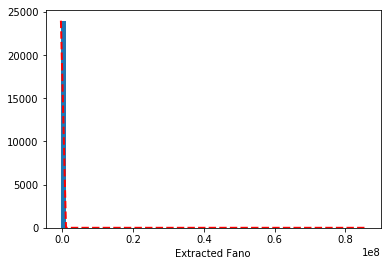

mean : -1001135.0773387668 , uncertainty in mean :  1.4378021170829594e+17
[[ 1.74655673e+15 -1.58467756e+16  2.80382544e+15]
 [-1.58467756e+16  1.43780212e+17 -2.54395358e+16]
 [ 2.80382544e+15 -2.54395358e+16  4.50110607e+15]]
3.1711050759142916 5.577488638960896


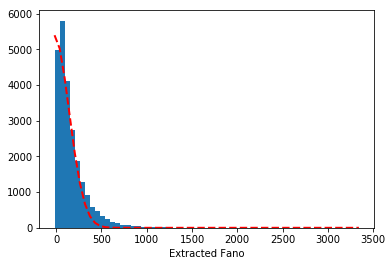

mean : -25.829156239580424 , uncertainty in mean :  280.73981237549685
[[26926.198489   -2072.72453278  1001.42429829]
 [-2072.72453278   280.73981238  -168.25947752]
 [ 1001.42429829  -168.25947752   117.93421328]]
5.577569668587628 7.953881947911727


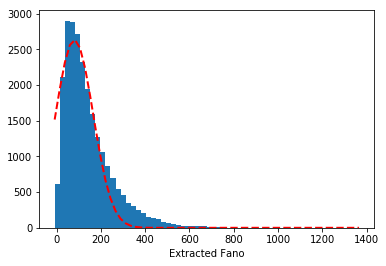

mean : 80.42696801085901 , uncertainty in mean :  18.211537559782215
[[ 9.50730763e+03  6.32422598e+01 -2.75531576e+02]
 [ 6.32422598e+01  1.82115376e+01 -8.05030866e+00]
 [-2.75531576e+02 -8.05030866e+00  2.27555722e+01]]
7.9539670056126885 10.443512816821206


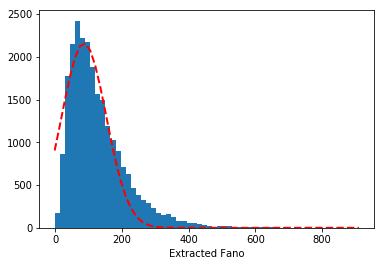

mean : 85.57526165035307 , uncertainty in mean :  9.301725883285652
[[ 6.43378374e+03  2.48810648e+01 -1.63292562e+02]
 [ 2.48810648e+01  9.30172588e+00 -2.47706503e+00]
 [-1.63292562e+02 -2.47706503e+00  1.14781426e+01]]
10.443572041379841 13.077172815546032


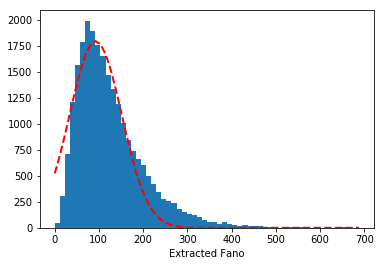

mean : 92.98521697617457 , uncertainty in mean :  5.879112959149345
[[ 3.94126552e+03  9.06050245e+00 -9.82971956e+01]
 [ 9.06050245e+00  5.87911296e+00 -8.46795342e-01]
 [-9.82971956e+01 -8.46795342e-01  6.86874193e+00]]
13.077194305393899 15.838802315589252


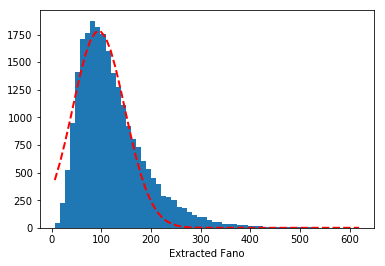

mean : 94.53819021866289 , uncertainty in mean :  3.9337699788744684
[[ 3.33440917e+03  5.05201195e+00 -7.25235854e+01]
 [ 5.05201195e+00  3.93376998e+00 -4.06186916e-01]
 [-7.25235854e+01 -4.06186916e-01  4.46428718e+00]]
15.838941075246884 18.78769995873194


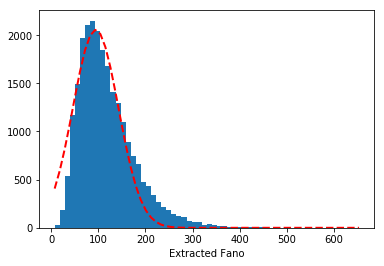

mean : 94.24441738051975 , uncertainty in mean :  2.9270234649923315
[[ 3.92537713e+03  3.24403238e+00 -6.64255157e+01]
 [ 3.24403238e+00  2.92702346e+00 -2.00240438e-01]
 [-6.64255157e+01 -2.00240438e-01  3.22030962e+00]]
18.787761176972808 21.992916131133974


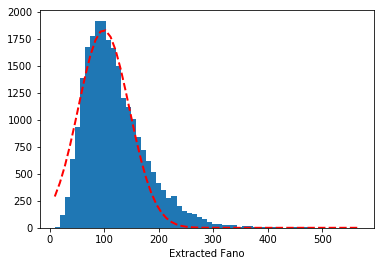

mean : 99.50141207040473 , uncertainty in mean :  2.422292133924905
[[ 2.78148525e+03  1.76636190e+00 -5.00467092e+01]
 [ 1.76636190e+00  2.42229213e+00 -1.14933796e-01]
 [-5.00467092e+01 -1.14933796e-01  2.60521175e+00]]
21.992947075596344 25.515004821572354


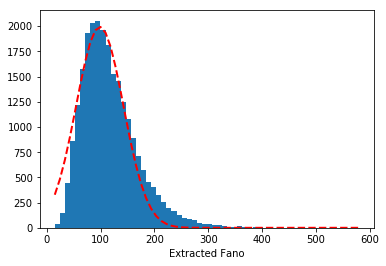

mean : 98.58372281917484 , uncertainty in mean :  1.6713458739813438
[[ 2.56599123e+03  1.46891193e+00 -4.00016514e+01]
 [ 1.46891193e+00  1.67134587e+00 -8.28691042e-02]
 [-4.00016514e+01 -8.28691042e-02  1.80209049e+00]]
25.51518301106991 29.340634025008896


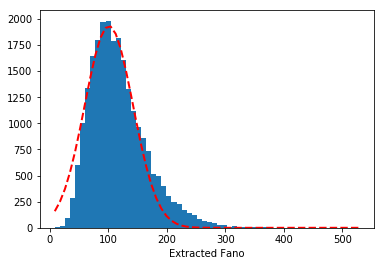

mean : 100.83933900136456 , uncertainty in mean :  1.4190689988033502
[[ 2.32688050e+03  3.94078695e-01 -3.38880666e+01]
 [ 3.94078695e-01  1.41906900e+00 -2.02092977e-02]
 [-3.38880666e+01 -2.02092977e-02  1.45878511e+00]]
29.34070931709865 33.54537015634968


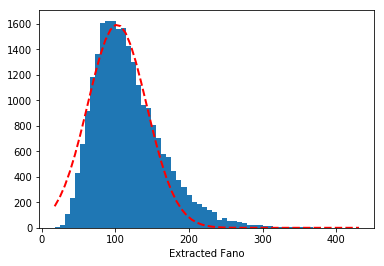

mean : 102.54444426237187 , uncertainty in mean :  1.435863779942609
[[ 1.71583340e+03  5.68585606e-01 -2.96106109e+01]
 [ 5.68585606e-01  1.43586378e+00 -3.49670598e-02]
 [-2.96106109e+01 -3.49670598e-02  1.49896107e+00]]
33.545542020119484 38.234627657069055


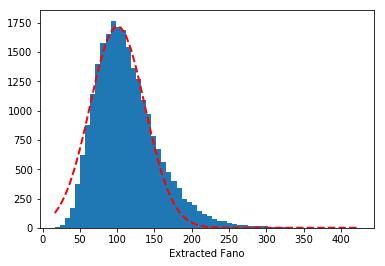

mean : 100.32973068151227 , uncertainty in mean :  0.789128849561428
[[ 1.30351098e+03  1.87941072e-01 -1.88630310e+01]
 [ 1.87941072e-01  7.89128850e-01 -9.54811311e-03]
 [-1.88630310e+01 -9.54811311e-03  8.08308794e-01]]
38.234713406179274 43.63701956200476


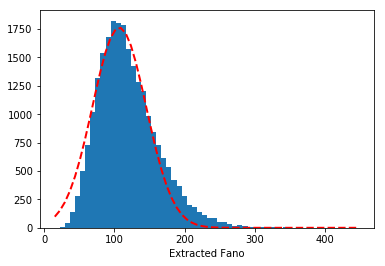

mean : 106.83136646240642 , uncertainty in mean :  0.9338563552054072
[[ 1.49620487e+03  1.35246327e-01 -2.18446991e+01]
 [ 1.35246327e-01  9.33856355e-01 -6.86403081e-03]
 [-2.18446991e+01 -6.86403081e-03  9.48564062e-01]]
43.637289943199846 49.81847133579248


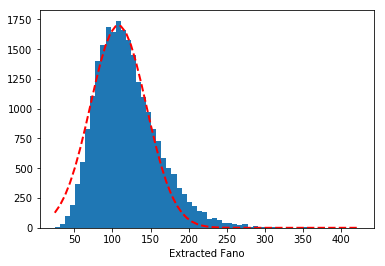

mean : 107.69141496058468 , uncertainty in mean :  0.7845465579133767
[[ 1.27595416e+03  1.93304304e-01 -1.86209580e+01]
 [ 1.93304304e-01  7.84546558e-01 -9.91311216e-03]
 [-1.86209580e+01 -9.91311216e-03  8.04337843e-01]]
49.81847644198457 57.204331467143746


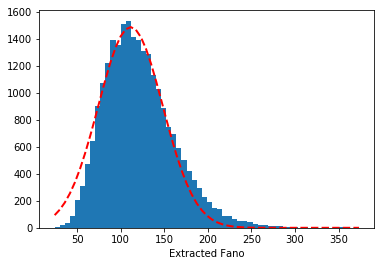

mean : 111.40337099814299 , uncertainty in mean :  0.6248280326220015
[[ 7.55476356e+02  1.05591735e-01 -1.27425451e+01]
 [ 1.05591735e-01  6.24828033e-01 -6.23038946e-03]
 [-1.27425451e+01 -6.23038946e-03  6.37659565e-01]]
57.20471964735273 66.08991853993302


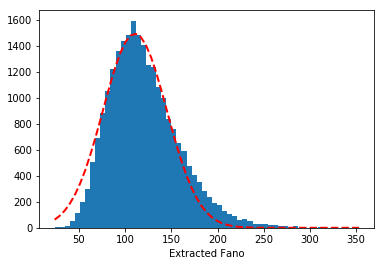

mean : 110.53043302693095 , uncertainty in mean :  0.5832099202723071
[[ 8.18151853e+02  5.21437571e-02 -1.27175848e+01]
 [ 5.21437571e-02  5.83209920e-01 -2.79607704e-03]
 [-1.27175848e+01 -2.79607704e-03  5.89496999e-01]]
66.09041649263543 77.53034781628358


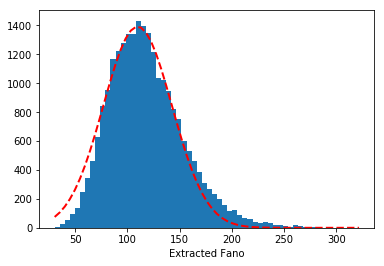

mean : 109.76945612600787 , uncertainty in mean :  0.3858743807815521
[[ 5.18906524e+02  5.36811485e-02 -8.27363350e+00]
 [ 5.36811485e-02  3.85874381e-01 -2.97942225e-03]
 [-8.27363350e+00 -2.97942225e-03  3.92210831e-01]]
77.53096377140074 93.73897248542028


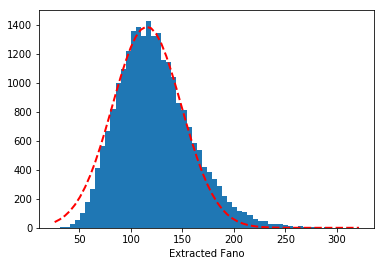

mean : 115.54420810740014 , uncertainty in mean :  0.35806398881343826
[[ 4.60488417e+02  1.57052132e-02 -7.44756682e+00]
 [ 1.57052132e-02  3.58063989e-01 -8.66104009e-04]
 [-7.44756682e+00 -8.66104009e-04  3.60151630e-01]]
93.7390475656454 121.612920117349


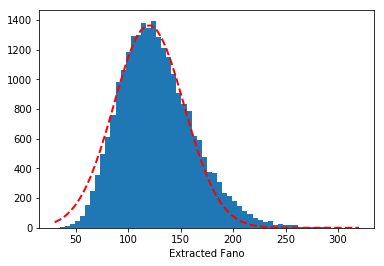

mean : 119.80931627970024 , uncertainty in mean :  0.3645955603016318
[[ 4.56030329e+02  1.48118586e-02 -7.47681734e+00]
 [ 1.48118586e-02  3.64595560e-01 -8.27226967e-04]
 [-7.47681734e+00 -8.27226967e-04  3.66601452e-01]]
121.61536447207163 593.0224795620531


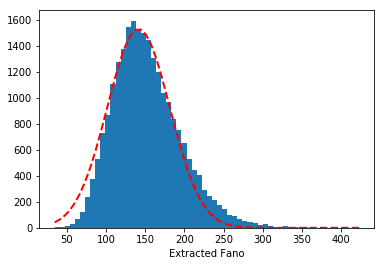

mean : 141.63512210141727 , uncertainty in mean :  0.6454573846183269
[[ 7.14303857e+02  2.33835134e-02 -1.24480472e+01]
 [ 2.33835134e-02  6.45457385e-01 -1.38670344e-03]
 [-1.24480472e+01 -1.38670344e-03  6.48838989e-01]]


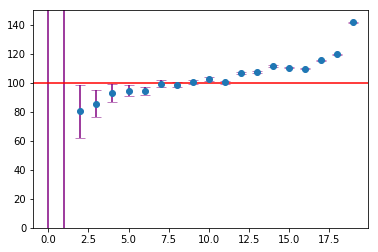

In [17]:
means,errors = calc_fano(data,sig)


x = np.arange(0,20)

plt.figure()
plt.errorbar(x,means,yerr=errors,fmt ='o',label = 'error', ecolor = 'purple', Linestyle = 'None', capsize=5, capthick=0.5)
plt.axhline(y=F, color='r', linestyle='-')
plt.ylim(0,150)
plt.show()